#Risk assessment

This notebook presents an exploration of different ways to assess the risk of recidivism based on a risk score.

Copyright 2015 Allen Downey

MIT License: http://opensource.org/licenses/MIT

In [15]:
from __future__ import print_function, division

import numpy as np
import pandas as pd
import thinkbayes2
import thinkplot

import matplotlib.pyplot as plt

import statsmodels.formula.api as smf

%matplotlib inline

The dataset I'm using comes from ???

In [16]:
df = pd.read_excel('helmus10yrfixed.xlsx')
df['recid'] = df['10-yr recidivate']
df.head()

,score,10-yr recidivate,recid
0,-2,0,0
1,-2,0,0
2,-1,0,0
3,-1,0,0
4,-1,0,0


The last row of the table is the total, so we have to drop it.

In [33]:
df.tail()

,score,10-yr recidivate,recid
699,10,1,1
700,10,1,1
701,10,1,1
702,11,0,0
703,NaN,204,204


Done.

In [34]:
df = df.dropna()
df.tail()

,score,10-yr recidivate,recid
698,10,1,1
699,10,1,1
700,10,1,1
701,10,1,1
702,11,0,0


Start with a logistic regression.

In [223]:
formula = 'recid ~ score'
model = smf.logit(formula, data=df)
results = model.fit(disp=False)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  recid   No. Observations:                  703
Model:                          Logit   Df Residuals:                      701
Method:                           MLE   Df Model:                            1
Date:                Wed, 04 Nov 2015   Pseudo R-squ.:                 0.03919
Time:                        15:51:59   Log-Likelihood:                -406.84
converged:                       True   LL-Null:                       -423.43
                                        LLR p-value:                 8.371e-09
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -1.8129      0.194     -9.335      0.000        -2.194    -1.432
score          0.2048      0.037      5.534      0.000         0.132     0.277
==============================================================================
"""

We can use the model to predict probabilities for each score:

In [229]:
scores = range(-2, 12)
scores

[-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [230]:
columns = ['score']
new = pd.DataFrame(scores, columns=columns)
ps = results.predict(new)
ps

array([ 0.09775397,  0.11735892,  0.14028437,  0.16684166,  0.19727288,
        0.23171097,  0.27013779,  0.31234649,  0.35791611,  0.4062068 ,
        0.45638189,  0.50745809,  0.55837907,  0.60810123])

And here's what that looks like graphically:

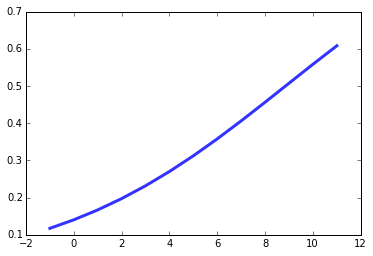

In [141]:
thinkplot.Plot(scores, ps)

Equivalently, we could get the fitted values from the results, which are in the form of log-odds, and convert to probabilities.

In [93]:
odds = np.exp(results.fittedvalues)
ps = odds / (1 + odds)
ps.head()

0    0.097754
1    0.097754
2    0.117359
3    0.117359
4    0.117359
dtype: float64

To show confidence intervals on the estimated probabilities, we could transform the confidence intervals on the estimated parameters, but I prefer to do it by resampling.

Here's a simple version that plots 200 estimated lines to show uncertainty visually.

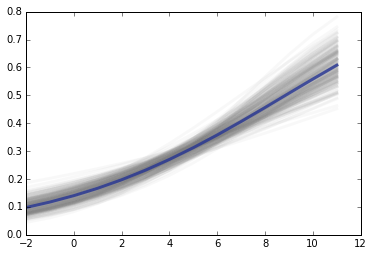

In [233]:
def plot_regression_lines(df):
    scores = range(-2, 12)
    columns = ['score']
    new = pd.DataFrame(scores, columns=columns)

    formula = 'recid ~ score'

    for i in range(200):
        sample = df.sample(len(df), replace=True)
        model = smf.logit(formula, data=sample)
        results = model.fit(disp=False)
        ps = results.predict(new)
        thinkplot.Plot(scores, ps, color='gray', alpha=0.05)
        
plot_regression_lines(df)
thinkplot.Plot(scores, ps)

Here's a more complicated version that plots the median of the resampled estimates in each column, and a 95% confidence interval.

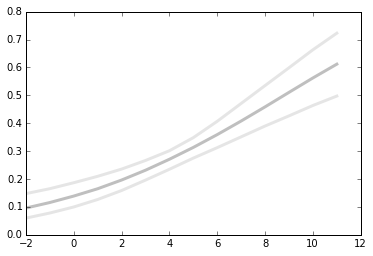

In [238]:
scores = range(-2, 12)

def run_regressions(df, iters=1000, formula='recid ~ score', color='gray'):
    columns = ['score']
    new = pd.DataFrame(scores, columns=columns)
    new['score2'] = new.score**2
    
    array = np.zeros((iters, len(scores)))

    for i in range(iters):
        sample = df.sample(len(df), replace=True)
        model = smf.logit(formula, data=sample)
        results = model.fit(disp=False)
        ps = results.predict(new)
        array[i,] = ps

    array = np.sort(array, axis=0)    
    percents = [2.5, 50, 97.5]
    rows = [thinkstats2.PercentileRow(array, p) for p in percents]
    return rows
    
def plot_regressions(df, iters=1000, formula='recid ~ score', color='gray'):
    rows = run_regressions(df, iters, formula, color)
    thinkplot.Plot(scores, rows[0], color=color, alpha=0.2)
    thinkplot.Plot(scores, rows[1], color=color, alpha=0.5)
    thinkplot.Plot(scores, rows[2], color=color, alpha=0.2)
    
plot_regressions(df, iters=1000)

An alternative is Bayesian regression.  To demonstrate how it works, I'll use the parameters estimated by logistic regression to compute the likelihood of the data.

In [87]:
slope, inter = (results.params['score'], results.params['Intercept'])
slope, inter

(0.20475163024127738, -1.8129301177982706)

We can use the parameters to compute log-odds, convert to probabilities, then compute the probability of each actual outcome.

In [94]:
log_odds = df.score * slope + inter
odds = np.exp(log_odds)
ps = odds / (1 + odds)
likes = ps * df.recid + (1-ps) * (1-df.recid)
likes.head()

0    0.902246
1    0.902246
2    0.882641
3    0.882641
4    0.882641
dtype: float64

The product of these likelihoods is the likelihood of the data.  The log-likelihood we get is the same as the output of the logistic regression:

In [240]:
np.log(np.prod(likes)), results.llf

(-406.83547329540573, -406.83547329540579)

Now here's a Bayesian suite that computes this likelihood function:

In [241]:
class BLogit(thinkbayes2.Suite, thinkbayes2.Joint):
    
    def Likelihood(self, df, hypo):
        """The likelihood of the data under the hypothesis.
        
        df: DataFrame with score and recid
        hypo: slope, intercept pair
        
        returns: float
        """
        slope, inter = hypo
        log_odds = df.score * slope + inter
        odds = np.exp(log_odds)
        ps = odds / (1 + odds)
        likes = ps * df.recid + (1-ps) * (1-df.recid)
        like = np.prod(likes)
        return like

And we can confirm again that it yields the same likelihood, given the parameters estimated by logistic regression

In [242]:
hypo = (slope, inter)
blogit = BLogit()
like = blogit.Likelihood(df, hypo)
np.log(like), results.llf

(-406.83547329540573, -406.83547329540579)

We can generate the Bayesian estimate of the parameters by generating a suite of hypothesis and computing the likelihood of the data under each.

I'll start with a uniform distribution for both parameters (using the confidence intervals from logistic regression to choose the bounds).

In [245]:
hypos = [(slope, inter) for slope in np.linspace(0, 0.4, 101)
                        for inter in np.linspace(-3, 0, 101)]

Initialize the suite:

In [246]:
blogit = BLogit(hypos)

And update with the data:

In [247]:
like = blogit.Update(df)
np.log(like)

-410.95822860613788

The marginal distribution of the slope parameter:

(0.13600000000000001, 0.28000000000000003)

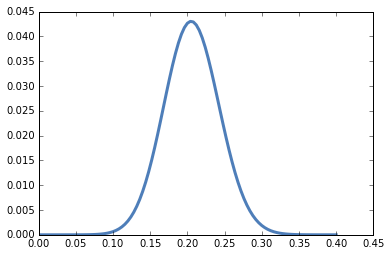

In [248]:
pmf_slope = blogit.Marginal(0)
thinkplot.Pdf(pmf_slope)
pmf_slope.CredibleInterval(95)

And for the intercept parameter:

(-2.2199999999999998, -1.4399999999999999)

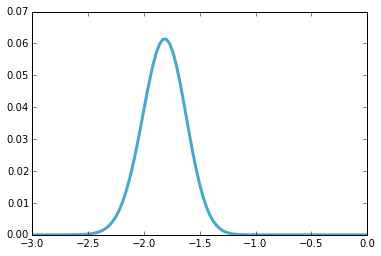

In [249]:
pmf_inter = blogit.Marginal(1)
thinkplot.Pdf(pmf_inter)
pmf_inter.CredibleInterval(95)

And here's the joint distribution

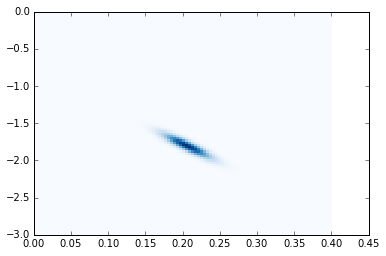

In [98]:
thinkplot.Contour(blogit, pcolor=True, contour=False)

From the posterior distribution of the parameters, we can generate a predictive distribution of probability for each score:

In [82]:
def make_predictive(blogit, score):
    pmf = thinkbayes2.Pmf()
    for (slope, inter), prob in blogit.Items():
        x = score * slope + inter
        o = np.exp(x)
        p = o / (1+o)
        pmf[p] = prob
    return pmf

Here's what the posterior predictive distributions look like for a range of scores.

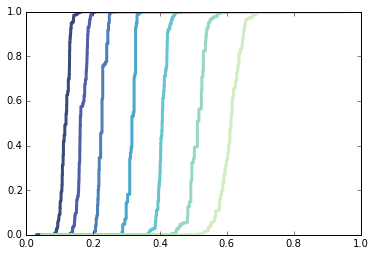

In [155]:
scores = [-1, 1, 3, 5, 7, 9, 11]
thinkplot.PrePlot(len(scores))
for score in scores:
    pmf = make_predictive(blogit, score)
    thinkplot.Cdf(pmf.MakeCdf())

We can also plot the results with a line plot and 95% credible intervals.

In [156]:
cdfs = [make_predictive(blogit, score).MakeCdf() for score in scores]

Extracting the medians and credible intervals from the posterior predictive distributions.

In [157]:
medians = np.array([cdf.Percentile(50) for cdf in cdfs])
cis = np.array([cdf.CredibleInterval(95) for cdf in cdfs])

And here's what they look like.

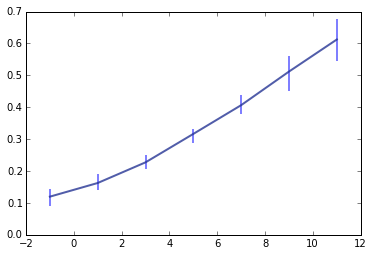

In [251]:
def plot_bayesian_regression(scores, medians, cis):
    for score, (low, high) in zip(scores, cis):
        plt.vlines(score, low, high, color='blue', alpha=0.5, linewidth=2)
    thinkplot.PrePlot(1)
    thinkplot.plot(scores, medians, linewidth=2)

scores = [-1, 1, 3, 5, 7, 9, 11]
plot_bayesian_regression(scores, medians, cis)

If we superimpose the lines from the logistic regression, we can compare them:

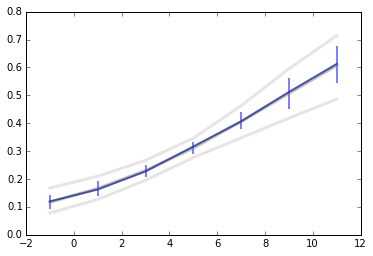

In [252]:
plot_regressions(df)

scores = [-1, 1, 3, 5, 7, 9, 11]
plot_bayesian_regression(scores, medians, cis)

The Bayesian and logistic regressions agree about the median values.  The credible intervals for the Bayesian regression are somewhat smaller than the confidence intervals for the logistic regression.

Next we can explore another way to estimate risk for each group.

If we treat score as a categorical variable, we can estimate risk for each score separately.

In [255]:
grouped = df.groupby('score')
for name, group in grouped:
    print(name, len(group))

-2.0 2
-1.0 24
0.0 31
1.0 56
2.0 42
3.0 82
4.0 130
5.0 133
6.0 83
7.0 61
8.0 32
9.0 17
10.0 9
11.0 1


I'll use a Beta distribution for each group.

In [256]:
def MakeBeta(group):
    yes = sum(group.recid == 1)
    no = sum(group.recid==0)
    beta = thinkstats2.Beta(yes+1, no+1)
    return beta

betas = {}
for name, group in grouped:
    betas[name] = MakeBeta(group)

And then extract the median and 95% credible interval from each posterior.

In [257]:
rows=[]
for name, beta in sorted(betas.items()):
    cdf = beta.MakeCdf()
    low = cdf.Percentile(2.5)
    mean = beta.Mean()
    high = cdf.Percentile(97.5)
    rows.append((low, mean, high))
    
array = np.array(rows).transpose()
scores = sorted(betas)
lows = array[0,]
means = array[1,]
highs = array[2,]

The result is kind of a mess, with credible intervals much wider than the CIs from logistic regression.

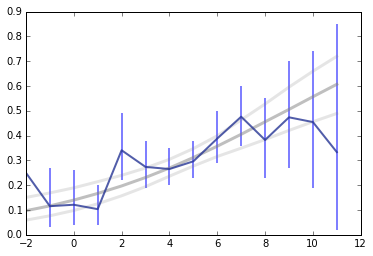

In [259]:
plot_regressions(df)

for score, low, high in zip(scores, lows, highs):
        plt.vlines(score, low, high, color='blue', alpha=0.5, linewidth=2)
        
thinkplot.PrePlot(1)
thinkplot.plot(scores, means, linewidth=2)

One last option to consider is a quadratic model of risk.

Here the linear model again:

In [212]:
formula = 'recid ~ score'
model = smf.logit(formula, data=df)
results = model.fit(disp=False)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  recid   No. Observations:                  703
Model:                          Logit   Df Residuals:                      701
Method:                           MLE   Df Model:                            1
Date:                Wed, 04 Nov 2015   Pseudo R-squ.:                 0.03919
Time:                        14:32:25   Log-Likelihood:                -406.84
converged:                       True   LL-Null:                       -423.43
                                        LLR p-value:                 8.371e-09
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -1.8129      0.194     -9.335      0.000        -2.194    -1.432
score          0.2048      0.037      5.534      0.000         0.132     0.277
==============================================================================
"""

And here's the quadratic version.

In [217]:
df['score2'] = df.score**2

formula = 'recid ~ score + score2'
model = smf.logit(formula, data=df)
results = model.fit(disp=False)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  recid   No. Observations:                  703
Model:                          Logit   Df Residuals:                      700
Method:                           MLE   Df Model:                            2
Date:                Wed, 04 Nov 2015   Pseudo R-squ.:                 0.04235
Time:                        14:35:36   Log-Likelihood:                -405.49
converged:                       True   LL-Null:                       -423.43
                                        LLR p-value:                 1.626e-08
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -2.1210      0.288     -7.354      0.000        -2.686    -1.556
score          0.3820      0.119      3.209      0.001         0.149     0.615
score2        -0.0193      0.012     -1.601      0.109        -0.043     0.004
==============================================================================
"""

The square term is not significant.

Also if we plot the predictions of the two models:

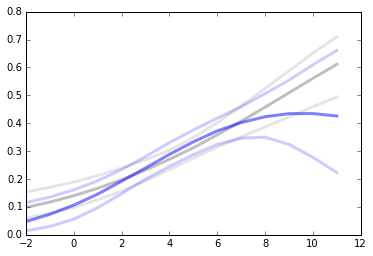

In [261]:
plot_regressions(df, formula='recid ~ score')
plot_regressions(df, formula='recid ~ score + score2', color='blue')

The quadratic model is getting pulled down by the low recidivism rates in the highest groups, which are based on small sample sizes.  So this model is likely overfit to the data.